In [1]:
import numpy as np
import casadi
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'MS Gothic'

In [2]:
coef_0 = 1.750
coef_1 = -0.902
coef_2 = -0.01

def oscillator_eq(z_kp1, z_k, u):
    z_kp2 = coef_0 * z_kp1 + coef_1 * z_k + coef_2 * z_k ** 3
    return z_kp2 + u

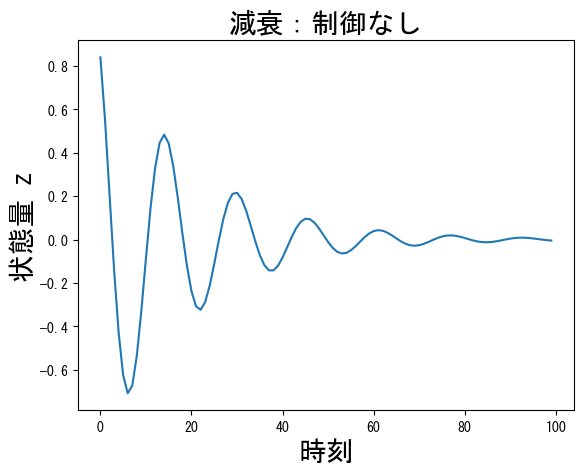

In [3]:
Z_k = []
z_kp1 = 1
z_k = 1

for t in range(100):
    z_kp2 = oscillator_eq(z_kp1, z_k, 0)
    Z_k.append(z_kp2)

    z_k = z_kp1
    z_kp1 = z_kp2
    
    
plt.title("減衰：制御なし",fontsize=20)
plt.xlabel("時刻",fontsize=20)
plt.ylabel("状態量 z",fontsize=20)
plt.plot(Z_k)
plt.savefig("images/chap4_mpc_no_control.png")
plt.show()

In [4]:
n_horizon = 10 #ホライズン長
x_k = np.array([0, 0]).T #初期値
z_ref = 1 #参照軌道（z=1）

_x_0 = casadi.SX.sym('x_0') # xの第0成分
_x_1 = casadi.SX.sym('x_1') # xの第1成分
_u = casadi.SX.sym('u') # 制御入力u

_X_traj = casadi.SX.sym('x_traj', n_horizon, 2) # xの予測軌道
_U_traj = casadi.SX.sym('u_traj', n_horizon-1, 1) # uの予測軌道

# 状態方程式
_f = casadi.Function('dynamics', [_x_0, _x_1, _u],
         [casadi.vertcat(
            oscillator_eq(_x_0, _x_1, _u),
           _x_0
        )])

def make_constraints(x_k):
   # 各種制約条件
   g = []
   lbg = [] 
   ubg = []

   # 初期条件の制約
   g += [_X_traj[0,:].T - x_k]
   lbg += [0, 0]
   ubg += [0, 0]

   # 状態方程式の制約
   for l in range(1, n_horizon):
      g += [_X_traj[l,:].T - \
      _f(_X_traj[l-1,0],_X_traj[l-1,1], _U_traj[l-1])]
      lbg += [0, 0]
      ubg += [0, 0]

   # 状態と入力に対する制約
   lbw = [-np.inf]*_X_traj.numel() + \
         [-0.2]*_U_traj.numel()
   ubw = [np.inf]*_X_traj.numel() + \
         [0.2]*_U_traj.numel()

   return g, lbg, ubg, lbw, ubw

g, lbg, ubg, lbw, ubw  = make_constraints(x_k)

In [5]:
def make_J(_X_traj, _U_traj, z_ref):
    #コスト関数
    J = 0

    # 目標との二乗誤差
    for l in range(1, n_horizon):
        J += 0.1 * (_X_traj[l, 0] - z_ref) ** 2

    # 速度に対する正則化
    for l in range(n_horizon-1):
        J += 0.5 * (_X_traj[l+1,0] - _X_traj[l,0]) ** 2

    # uの変動に対する正則化
    for l in range(n_horizon-2):
        J += 0.1 * (_U_traj[l+1,0] - _U_traj[l,0]) ** 2

    return J


J = make_J(_X_traj, _U_traj, z_ref)

In [6]:
def programming(_X_traj, _U_traj, x_k):
    g, lbg, ubg, lbw, ubw  = make_constraints(x_k)
    nlp = {'x': casadi.vertcat(
        casadi.reshape(_X_traj,-1,1), _U_traj),
        'f':J,
        'g':casadi.vertcat(*g)}
    sol = casadi.nlpsol('sol', 'ipopt', nlp)

    res = sol(
        x0=np.zeros(n_horizon*3-1),
        lbx=lbw, ubx=ubw,
        lbg=lbg, ubg=ubg)

    return res


res = programming(_X_traj, _U_traj, x_k)

opt = np.array(res['x'])

x_traj_res = opt[:n_horizon]
u_traj_res = opt[2*n_horizon:]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       56
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       29
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality c

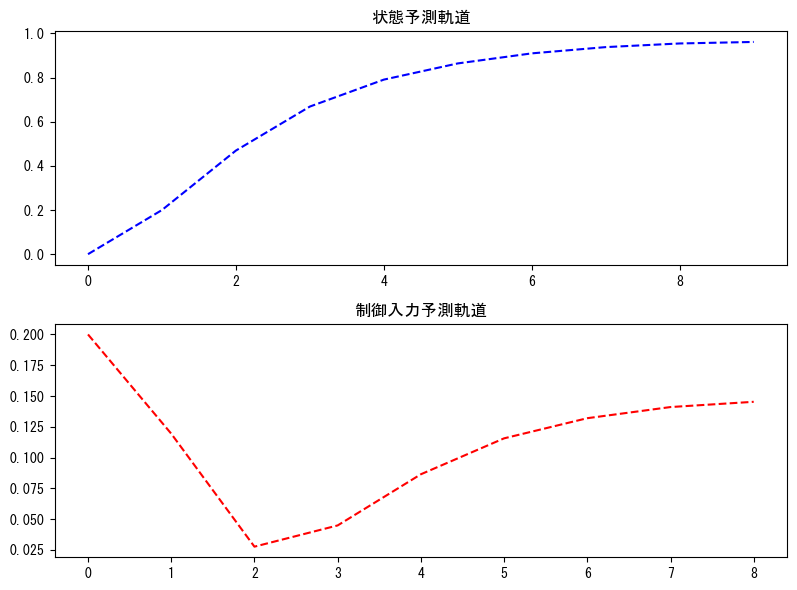

In [7]:
fig, axes = plt.subplots(2,1,figsize=(8,6))

axes[0].plot(x_traj_res, c="blue", linestyle="--")
axes[0].set_title("状態予測軌道")
axes[1].plot(u_traj_res, c="red", linestyle="--")
axes[1].set_title("制御入力予測軌道")

plt.tight_layout()
plt.savefig("images/chap4_predict_traj.png")
plt.show()

In [8]:
import io 
from PIL import Image

X_k = []
U_k = []

x_k = np.array([0, 0])
sim_time = 30

images = []

for k in range(sim_time):
    res = programming(_X_traj, _U_traj, x_k)
    opt = np.array(res['x'])
    x_traj_res = opt[:n_horizon]
    u_traj_res = opt[2*n_horizon:]

    z_tp2 = oscillator_eq(x_k[0], x_k[1], u_traj_res[0])
    X_k.append(x_k[0])
    U_k.append(u_traj_res[0])

    x_k = np.array([z_tp2, x_k[0]])

    fig, axes = plt.subplots(2,1,figsize=(12,6))

    fig.suptitle("MPC制御", fontsize=30)

    axes[0].set_title("状態量z", fontsize=20)
    axes[0].plot(X_k, c="blue")
    axes[0].scatter(len(X_k)-1, X_k[-1], c="blue")
    axes[0].plot(range(len(X_k)-1, len(X_k) + \
                       x_traj_res.shape[0]-1), \
                        x_traj_res, c="blue", linestyle="--")
    axes[0].set_xlim(0,sim_time+x_traj_res.shape[0]-5)
    axes[0].set_ylim(-0.1, 1.2)

    axes[1].set_title("制御入力u", fontsize=20)
    axes[1].plot(U_k, c="red")
    axes[1].scatter(len(U_k)-1, U_k[-1], c="red")
    axes[1].plot(range(len(X_k)-1, len(X_k) + \
                       u_traj_res.shape[0]-1), \
                        u_traj_res, c="red", linestyle="--")
    axes[1].set_xlim(0,sim_time+x_traj_res.shape[0]-5)
    axes[1].set_ylim(-0.25,0.25)

    plt.tight_layout()
    buf = io.BytesIO() 
    plt.savefig(buf, format='jpg') # bufferに保持
    buf.seek(0)

    dst = np.array(Image.open(buf)) # bufferからの読み出し
    
    plt.cla()
    plt.clf()
    plt.close()
    images.append(Image.fromarray(dst))


images[0].save('images/chap4_descrete_MPC.gif',
            save_all=True, append_images=images[1:],
            optimize=False, duration=100, loop=0)

print("END")
    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       56
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       29
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.0000000e-01 0.00e+00 1.60e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

C:\Users\takuya.fukatsu\AppData\Local\Temp\ipykernel_23052\1311913340.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_k = np.array([z_tp2, x_k[0]])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       56
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       29
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.0000000e-01 2.00e-01 1.60e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

c:\Users\takuya.fukatsu\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       56
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       45

Total number of variables............................:       29
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.0000000e-01 4.63e-01 1.60e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 